In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
pip install opencv-python


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [9]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [10]:
# Generate random unique image names
import uuid

In [11]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [12]:
# Setup File Paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [13]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [14]:
# Uncompress labelled faces in the tar dataset
!tar -xf lfw.tgz

In [15]:
# Move lfw to the data/negative folder
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        CUR_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(CUR_PATH, NEW_PATH)

In [16]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\03518a69-304c-11ef-bb49-a8fbefe3552a.jpg'

In [15]:
# Camera Availability

cam_avail = []

for camera in range(10):
    cap = cv2.VideoCapture(camera)
    if cap.isOpened():
        print("Cameras available:", camera)
        cam_avail.append(camera)
        cap.release()
print(cam_avail)

Cameras available: 0
[0]


In [17]:
# Establishing Connection to WebCam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut down frame to 250x250px
    frame = frame[120:120+250, 200:200+250]

    # Collecting Anchor
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Save the anchor image
        cv2.imwrite(imgname, frame)

    cv2.imshow("Image Collected", frame)

    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

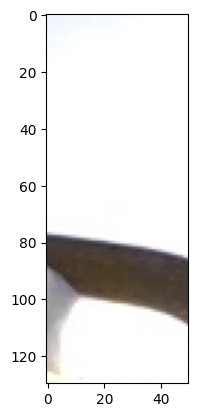

In [18]:
plt.imshow(frame[120:120+250, 200:200+250, :])

In [19]:
# Collecting Positive Images
import time
number_images = 6

cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print("Collecting image {}".format(imgnum))
    ret, frame = cap.read()
    # Tempo
    frame = frame[120:120+250, 200:200+250, :]

    imgname = os.path.join(POS_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('6 Images',frame)
    time.sleep(5)

    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [20]:
# Create a Dataset of each type of image
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(6)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(6)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(6)

In [21]:
dir_test = anchor.as_numpy_iterator()

In [22]:
print(dir_test.next())

b'data\\anchor\\2bca4ec9-304c-11ef-aa81-a8fbefe3552a.jpg'


In [22]:
# Preprocess - Scale and Resizing Image

In [23]:
def preprocess(file_path):

    # Read image from the file path
    byte_img = tf.io.read_file(file_path)
    # Decode byte string to Array
    img = tf.io.decode_jpeg(byte_img)

    # Resize the image to be 100x100
    img = tf.image.resize(img, (100, 100))

    img = img/255.0
    return img

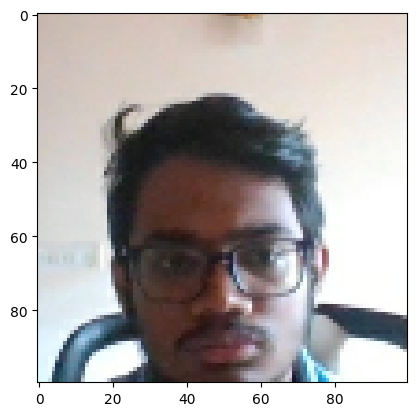

In [24]:
img = preprocess('data\\anchor\\2bca4ec9-304c-11ef-aa81-a8fbefe3552a.jpg')
plt.imshow(img)

In [25]:
# Create Labelled Data Set

In [25]:
positives = tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))

# Combining  the positive and negative data sets  into one

data = positives.concatenate(negatives)

In [26]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [27]:
samples = data.as_numpy_iterator()

In [28]:
ex = samples.next()
ex

(b'data\\anchor\\2bca4ec9-304c-11ef-aa81-a8fbefe3552a.jpg',
 b'data\\positive\\3cc87da5-304c-11ef-b5aa-a8fbefe3552a.jpg',
 1.0)

In [24]:
# BUILD TRAIN & TEST

In [29]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [34]:
res = preprocess_twin(*ex)

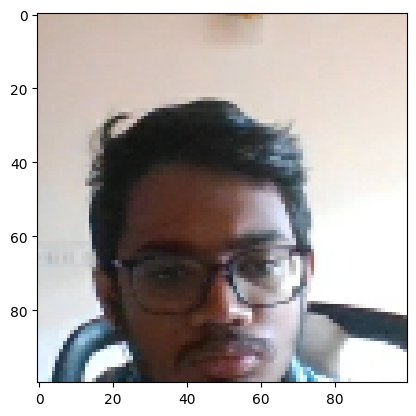

In [35]:
plt.imshow(res[1])
# res[0] - Shows the anchor image
# res[1] - Shows the positive/negative image dependent on the 'ex' value
# res[2] - Shows the Labelled Value for the 2 datasets
# Label value is '1' - For 'anchor' and 'positive' image
# Label value is '0' - For 'anchor' and 'negative' image

In [32]:
res[2]

1.0

In [38]:
# Build DataLoader Pipeline


In [36]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [37]:
# Training Part

# 70% of the data is taken first
train_data = data.take(round(len(data)*0.7))

# Now the data will be sent in a batch of 16
train_data = train_data.batch(16)

# Starts preprocessing the next set of images so that we don't bottleup our neural network
train_data = train_data.prefetch(8)

In [38]:
# Refine/ Testing Phase
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [39]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [36]:
# EMBEDDING LAYER

In [40]:
inp = Input(shape=(100,100,3), name="input_img")

In [41]:
cl1 = Conv2D(64, (10,10), activation='relu')(inp)

In [42]:
cl1

<KerasTensor shape=(None, 91, 91, 64), dtype=float32, sparse=False, name=keras_tensor>

In [43]:
m1 = MaxPooling2D(64,(2,2),padding='same')(cl1)

In [44]:
m1

<KerasTensor shape=(None, 46, 46, 64), dtype=float32, sparse=False, name=keras_tensor_1>

In [45]:
cl2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(cl2)

print(cl2)
print(m2)

<KerasTensor shape=(None, 40, 40, 128), dtype=float32, sparse=False, name=keras_tensor_2>
<KerasTensor shape=(None, 20, 20, 128), dtype=float32, sparse=False, name=keras_tensor_3>


In [46]:
cl3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(cl3)

print(cl3)
print(m3)

<KerasTensor shape=(None, 17, 17, 128), dtype=float32, sparse=False, name=keras_tensor_4>
<KerasTensor shape=(None, 9, 9, 128), dtype=float32, sparse=False, name=keras_tensor_5>


In [47]:
cl4 = Conv2D(256, (4,4), activation='relu')(m3)

# flattning all the output of CNN layer which are in 3D into a single Dimension
f1 = Flatten()(cl4)
d1 = Dense(4096, activation='sigmoid')(f1)

print(cl4)
print(f1)
print(d1)

<KerasTensor shape=(None, 6, 6, 256), dtype=float32, sparse=False, name=keras_tensor_6>
<KerasTensor shape=(None, 9216), dtype=float32, sparse=False, name=keras_tensor_7>
<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_8>


In [48]:
mod = Model(inputs=[inp], outputs=[d1], name="Embedding")

In [49]:
mod.summary()

Model: "Embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)          │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
def make_embedding():

    # First Layer
    inp = Input(shape=(100,100,3), name="input_img")
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second Layer
    cl2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(cl2)

    # Third Layer
    cl3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(cl3)

    # Fourth Layer 
    cl4 = Conv2D(256, (4,4), activation='relu')(m3)

    # flattning all the output of CNN layer which are in 3D into a single Dimension
    f1 = Flatten()(cl4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp], outputs=[d1], name="Embedding")

In [51]:
em = make_embedding()
em.summary()

Model: "Embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)          │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
type(em)

keras.src.models.functional.Functional

In [53]:
# BUILDING DISTANCE LAYER

In [54]:
class L1Dist(Layer):

    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# Subtracting cause we want to determine the similarity between them

In [55]:
em = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten()
])

In [56]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100, 100, 3))

In [57]:
em(input_image)

<KerasTensor shape=(None, 76832), dtype=float32, sparse=False, name=keras_tensor_22>

In [58]:
inp_embedding = em(input_image)
val_embedding = em(validation_image)

In [59]:
print(type(inp_embedding))

<class 'keras.src.backend.common.keras_tensor.KerasTensor'>


In [60]:
siamese_layer = L1Dist()

In [61]:
distances = siamese_layer(inp_embedding, val_embedding)

In [62]:
type(distances)

keras.src.backend.common.keras_tensor.KerasTensor

In [63]:
classifier = Dense(1, activation='sigmoid')(distances)

In [64]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 76832)     │        896 │ input_img[0][0],  │
│ (Sequential)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 76832)     │          0 │ sequential[1][0], │
│                     │                   │            │ sequential[2][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │     76,833 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 77,729 (303.63 KB)

 Trainable params: 77,729 (303.63 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
def make_siamese_model():

    # Anchor image as input
    input_image = Input(name='input_img', shape=(100, 100, 3))

    # Validation image - Positive/Negative
    validation_image = Input(name='validation_img', shape=(100, 100, 3))

    # Combining all components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(em(input_image), em(validation_image))

    # Classification Layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [66]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 76832)     │        896 │ input_img[0][0],  │
│ (Sequential)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 76832)     │          0 │ sequential[3][0], │
│                     │                   │            │ sequential[4][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │     76,833 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 77,729 (303.63 KB)

 Trainable params: 77,729 (303.63 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# TRAINING MODEL

In [67]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [68]:
opt = tf.keras.optimizers.Adam(1e-4)

In [68]:

# Establishing Checkpoints 

In [69]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)

In [70]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()

In [71]:
batch_1

(array([[[[0.76936275, 0.6987745 , 0.6517157 ],
          [0.7727941 , 0.7022059 , 0.64730394],
          [0.76887256, 0.6982843 , 0.6433824 ],
          ...,
          [0.89117646, 0.8303922 , 0.78137255],
          [0.88308823, 0.8281863 , 0.79093134],
          [0.88039213, 0.8254902 , 0.79019606]],
 
         [[0.7678922 , 0.69534314, 0.6512255 ],
          [0.7642157 , 0.69215685, 0.64730394],
          [0.7754902 , 0.70490193, 0.65343136],
          ...,
          [0.89215684, 0.8276961 , 0.78186274],
          [0.89093137, 0.8308824 , 0.79534316],
          [0.89117646, 0.8362745 , 0.8009804 ]],
 
         [[0.7882353 , 0.70980394, 0.6745098 ],
          [0.77916664, 0.7012255 , 0.66519606],
          [0.7752451 , 0.6987745 , 0.65612745],
          ...,
          [0.9019608 , 0.8352941 , 0.79607844],
          [0.8990196 , 0.83235294, 0.79901963],
          [0.8901961 , 0.8352941 , 0.8       ]],
 
         ...,
 
         [[0.87083334, 0.95      , 0.9857843 ],
          [0.87867

In [72]:
X = batch_1[:2]

In [73]:
Y = batch_1[2]

In [74]:
# BUILD TRAIN FUNCTIONS

In [74]:
@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:

        # Anchor & Pos/Neg Image
        X = batch[:2]

        # Get Label
        Y = batch[2]

        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(Y, yhat)
    print(loss)

    # Calculate gradients 
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [76]:
# BUilding a training Loop 

In [75]:
def train(data, EPOCHS):

    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data)) # Shows Progress Bar

        # Loop through each Batch
        for idx, batch in enumerate(data):
            # Do training step here
            train_step(batch)
            progbar.update(idx+1)

        # Save Checkpoint
        if epoch % 10 ==0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [76]:
EPOCHS = 50

In [77]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step

 Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

 Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

 Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

 Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

 Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

 Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

 Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

 Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

 Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

 Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

 Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

 Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

 Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

 Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

 Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

 Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms

In [80]:
tf.config.list_physical_devices('GPU')

[]

In [81]:
tf.test.is_built_with_cuda()

False

In [119]:
pip install --force-reinstall tensorflow[and-cuda]

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually


  Using cached tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata (3.5 kB)
  Using cached tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
INFO: pip is looking at multiple versions of tensorflow[and-cuda] to determine which version is compatible with other requirements. This could take a while.
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.11.0-cp311-cp311-win_amd64.whl.metadata (2.5 kB)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.64.0-cp311-cp311-win_amd64.whl.metadata (3.4 kB)
  Using cached tensorflow_io_gcs_filesystem-0

In [75]:
# Evaluate Model and Make Predictions

In [78]:
from tensorflow.keras.metrics import Precision, Recall

In [79]:
test_input,test_val , y_true = test_data.as_numpy_iterator().next()

In [80]:
len(test_val)

4

In [81]:
y_true

array([1., 1., 1., 1.], dtype=float32)

In [82]:
test_var = test_data.as_numpy_iterator().next()

In [83]:
len(test_var)

3

In [84]:
test_var[2]

array([1., 1., 1., 1.], dtype=float32)

In [85]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


array([[0.99997604],
       [0.999982  ],
       [0.99999875],
       [0.9802222 ]], dtype=float32)

In [86]:
res=[]
for prediction in y_hat:
    if prediction > 0.5:
        res.append(1)
    else:
        res.append(0)

res

[1, 1, 1, 1]

In [87]:
y_true

array([1., 1., 1., 1.], dtype=float32)

In [99]:
# CALCULATING METRICS


In [88]:
# create a metric object

m = Recall()

# Calculate the recall value
m.update_state(test_var[2], y_hat)

# Return the recall result 
m.result().numpy()

1.0

In [89]:
# create a metric object
m= Precision()

# Calculate the precision value
m.update_state(test_var[2], y_hat)

# Return the precision result
m.result().numpy()

1.0

In [102]:
# VISUALIZE 

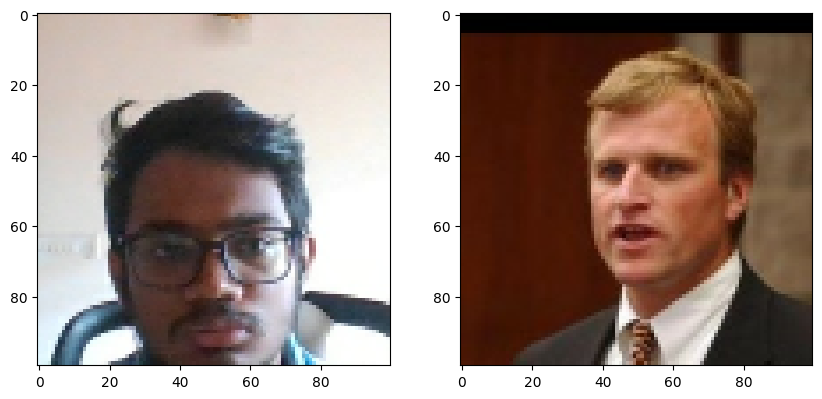

In [90]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[2])

plt.subplot(1,2,2)
plt.imshow(test_val[2])

plt.show()

In [105]:
# Save the model

In [91]:
siamese_model.save('siamese_model.h5')


In [92]:
# reload the model
model = tf.keras.models.load_model('siamese_model.h5' , custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [93]:
# make prediction with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


array([[0.99997604],
       [0.999982  ],
       [0.99999875],
       [0.9802222 ]], dtype=float32)

In [94]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 76832)     │        896 │ input_img[0][0],  │
│ (Sequential)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 76832)     │          0 │ sequential[0][0], │
│                     │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │     76,833 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 77,729 (303.63 KB)

 Trainable params: 77,729 (303.63 KB)

 Non-trainable params: 0 (0.00 B)

In [95]:
import os
path = "application_data/verification_images"
path1 = "application_data/input_image"
isExist = os.path.exists(path)
isExist = os.path.exists(path1)
if not isExist:
    os.makedirs(path)
if not isExist:
    os.makedirs(path1)

In [96]:
os.listdir(os.path.join('application_data', 'verification_images'))

[]

In [97]:
os.path.join('application_data', 'input_image', 'input_image.jpg') 

'application_data\\input_image\\input_image.jpg'

In [ ]:
# Add and delete function

In [98]:
#captured image from webcam will be stored in this folder
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [99]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

In [110]:
import shutil
import os
import glob

IMAGES_PATH = os.path.join('data', 'positive')

VER_PATH = os.path.join('application_data','verification_images')

for i in os.listdir(IMAGES_PATH):
    print(i)

a84b3b99-2fe9-11ef-b509-a8fbefe3552a.jpg
ab4f94ab-2fe9-11ef-b9da-a8fbefe3552a.jpg
ae4e6918-2fe9-11ef-b6b6-a8fbefe3552a.jpg
b14d8af5-2fe9-11ef-a604-a8fbefe3552a.jpg
b44c3846-2fe9-11ef-94a1-a8fbefe3552a.jpg
b749af85-2fe9-11ef-bcf8-a8fbefe3552a.jpg


In [111]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [100]:
def verify(model, detection_threshold ,verification_threshold):

    results = []
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_images = preprocess(os.path.join('application_data', 'input_image', 'input_images.jpg'))
        validation_img = preprocess(os.path.join('application_data','verification_images', image))

        # make predictions
        results - model.predict(list(np.expand_dims([input_image , validation_images], axis = 1)))
        result.append(result)

    detection = np.sum(np.array(results) > detection_threshold)

    # calculating for final verification
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

In [101]:
#webcam verification
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) 
        h, s, v = cv2.split(hsv)

        lim = 255 - 10
        v[v > lim] = 255
        v[v <= lim] -= 10
        
        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    
    k = cv2.waitKey(30) & 0xff
    if k == 113: 
        break
cap.release()
cv2.destroyAllWindows()

In [104]:
import os
import cv2

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    key = cv2.waitKey(30) & 0xff
    
    # Verification trigger
    if key == ord('v'):
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) 
        h, s, v = cv2.split(hsv)

        lim = 255 - 10
        v[v > lim] = 255
        v[v <= lim] -= 10
        
        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), img)
        # Run verification
        results, verified = verify(siamese_model, 1, 1)
        print(verified)
    
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
